In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Train image shape: (32, 32, 3), Train label shap: (10,)
Validation image shape: (32, 32, 3), Validation label Shape: (10,)
Test image shape: (10000, 32, 32, 3), Test label shape: (10000, 10)


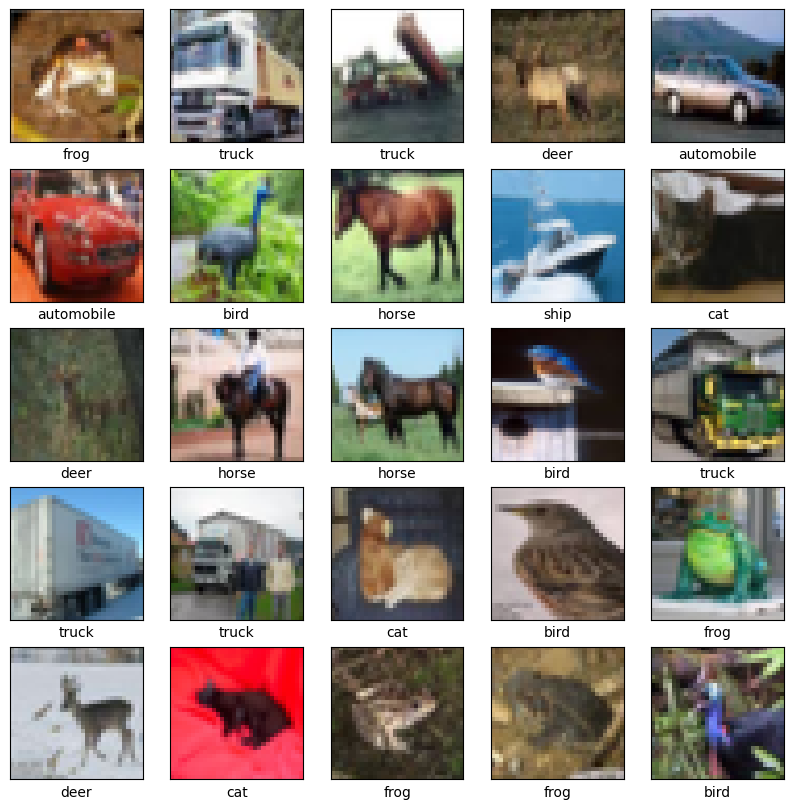

In [3]:
import tensorflow as tf

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


test_images = test_images.astype('float32')
train_images = train_images.astype('float32')


test_images = test_images / 255
train_images = train_images / 255


num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)


train_dataset, valid_dataset = keras.utils.split_dataset((train_images, train_labels), left_size=0.8, shuffle=True)


train_images_shape = tf.data.experimental.get_structure(train_dataset)[0].shape
train_labels_shape = tf.data.experimental.get_structure(train_dataset)[1].shape
val_images_shape = tf.data.experimental.get_structure(valid_dataset)[0].shape
val_labels_shape = tf.data.experimental.get_structure(valid_dataset)[1].shape

print(f"Train image shape: {train_images_shape}, Train label shap: {train_labels_shape}")
print(f"Validation image shape: {val_images_shape}, Validation label Shape: {val_labels_shape}")
print(f"Test image shape: {test_images.shape}, Test label shape: {test_labels.shape}")


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(train_images, train_labels)):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(label)])
    if i == 24:
        break

plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(ResNetBlock, 64, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResNetBlock, 64, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResNetBlock, 128, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResNetBlock, 256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(block(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer0(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet18 = ResNet18(3, 100).to(device)


print(model_resnet18)


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []


    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()


            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()


            lrs.append(optimizer.param_groups[0]['lr'])
            sched.step()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

ResNet18(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2

In [7]:
import torch


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step((batch[0].to(device), batch[1].to(device))) for batch in val_loader]
    return model.validation_epoch_end(outputs)


from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
initial_result = evaluate(model_resnet18, val_loader)
print(f"Initial Results - val_loss: {initial_result['val_loss']:.4f}, val_acc: {initial_result['val_acc']:.4f}")


epochs_resnet18 = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.SGD

Files already downloaded and verified
Initial Results - val_loss: 1.3537, val_acc: 0.5372


In [8]:

from torch.utils.data import DataLoader


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []


    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            loss = model.training_step((images, labels))
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()


            lrs.append(optimizer.param_groups[0]['lr'])
            sched.step()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

history_resnet18 = fit_one_cycle(epochs_resnet18, max_lr, model_resnet18, train_loader, val_loader, weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func)

Epoch [0], last_lr: 0.00152, train_loss: 1.0266, val_loss: 1.0722, val_acc: 0.6333
Epoch [1], last_lr: 0.00436, train_loss: 0.9970, val_loss: 1.0936, val_acc: 0.6212
Epoch [2], last_lr: 0.00760, train_loss: 0.8840, val_loss: 1.1053, val_acc: 0.6214
Epoch [3], last_lr: 0.00971, train_loss: 0.7530, val_loss: 0.9308, val_acc: 0.6839
Epoch [4], last_lr: 0.00994, train_loss: 0.6301, val_loss: 0.8699, val_acc: 0.7059
Epoch [5], last_lr: 0.00950, train_loss: 0.5086, val_loss: 0.8029, val_acc: 0.7399
Epoch [6], last_lr: 0.00867, train_loss: 0.4232, val_loss: 0.8021, val_acc: 0.7500
Epoch [7], last_lr: 0.00750, train_loss: 0.3249, val_loss: 0.8081, val_acc: 0.7553
Epoch [8], last_lr: 0.00611, train_loss: 0.2377, val_loss: 0.8627, val_acc: 0.7613
Epoch [9], last_lr: 0.00463, train_loss: 0.1604, val_loss: 0.8947, val_acc: 0.7702
Epoch [10], last_lr: 0.00317, train_loss: 0.0942, val_loss: 0.9935, val_acc: 0.7729
Epoch [11], last_lr: 0.00188, train_loss: 0.0507, val_loss: 1.0722, val_acc: 0.7777
Ep

100%|██████████| 170M/170M [00:03<00:00, 46.4MB/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
Initial Results with Residual - val_loss: 2.3035, val_acc: 0.0916
Initial Results without Residual - val_loss: 2.3028, val_acc: 0.1039

Training model with residual connections...

Epoch [1], last_lr: 0.00280, train_loss: 1.4548, val_loss: 1.5042, val_acc: 0.4928
Epoch [2], last_lr: 0.00760, train_loss: 1.2268, val_loss: 1.0808, val_acc: 0.6250
Epoch [3], last_lr: 0.01000, train_loss: 1.0503, val_loss: 1.2611, val_acc: 0.5680
Epoch [4], last_lr: 0.00950, train_loss: 0.9389, val_loss: 1.0445, val_acc: 0.6473
Epoch [5], last_lr: 0.00812, train_loss: 0.8693, val_loss: 0.8814, val_acc: 0.7049
Epoch [6], last_lr: 0.00611, train_loss: 0.7896, val_loss: 0.7915, val_acc: 0.7312
Epoch [7], last_lr: 0.00389, train_loss: 0.6873, val_loss: 0.7193, val_acc: 0.7434
Epoch [8], last_lr: 0.00188, train_loss: 0.5447, val_loss: 0.6254, val_acc: 0.7852
Epoch [9], last_lr: 0.00050, train_loss: 0.3242, val_loss: 0.5934, va

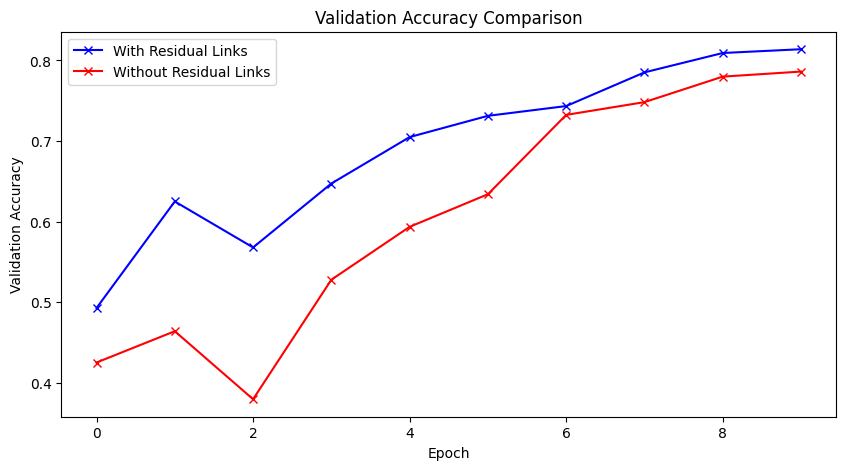

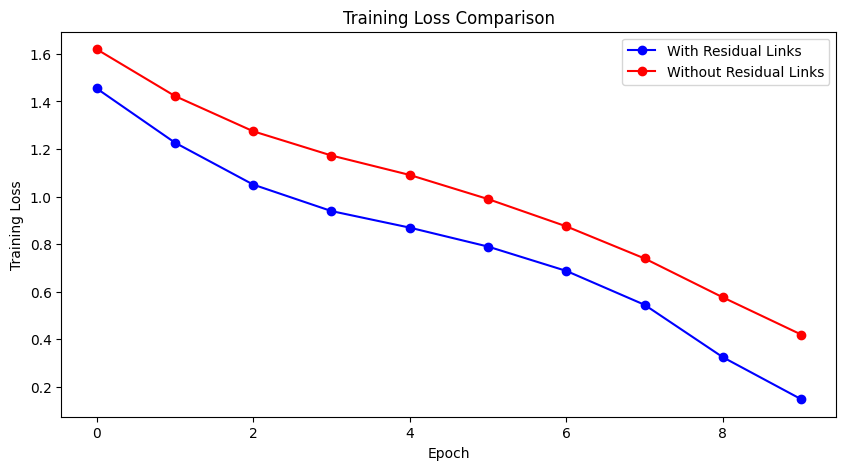

Test Results with Residual - val_loss: 0.6879, val_acc: 0.7942
Test Results without Residual - val_loss: 0.6614, val_acc: 0.7850


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step((batch[0].to(device), batch[1].to(device))) for batch in val_loader]
    return model.validation_epoch_end(outputs)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_residual=True):
        super().__init__()
        self.use_residual = use_residual
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if self.use_residual:
            self.shortcut = nn.Sequential()
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.use_residual:
            out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(ImageClassificationBase):
    def __init__(self, in_channels, num_classes, use_residual=True):
        super().__init__()
        self.use_residual = use_residual
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(ResNetBlock, 64, 64, 2, stride=1, use_residual=self.use_residual)
        self.layer2 = self._make_layer(ResNetBlock, 64, 128, 2, stride=2, use_residual=self.use_residual)
        self.layer3 = self._make_layer(ResNetBlock, 128, 256, 2, stride=2, use_residual=self.use_residual)
        self.layer4 = self._make_layer(ResNetBlock, 256, 512, 2, stride=2, use_residual=self.use_residual)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, in_channels, out_channels, blocks, stride, use_residual):
        layers = []
        layers.append(block(in_channels, out_channels, stride, use_residual))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, use_residual=use_residual))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer0(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []


    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()


            lrs.append(optimizer.param_groups[0]['lr'])
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

dataset = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)

val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

model_with_residual = ResNet18(in_channels=3, num_classes=10, use_residual=True).to(device)
model_without_residual = ResNet18(in_channels=3, num_classes=10, use_residual=False).to(device)

initial_result_with_residual = evaluate(model_with_residual, val_loader)
initial_result_without_residual = evaluate(model_without_residual, val_loader)
print(f"Initial Results with Residual - val_loss: {initial_result_with_residual['val_loss']:.4f}, val_acc: {initial_result_with_residual['val_acc']:.4f}")
print(f"Initial Results without Residual - val_loss: {initial_result_without_residual['val_loss']:.4f}, val_acc: {initial_result_without_residual['val_acc']:.4f}")


epochs_resnet18 = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

print("\nTraining model with residual connections...\n")
history_with_residual = fit_one_cycle(
    epochs_resnet18, max_lr, model_with_residual, train_loader, val_loader,
    weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func
)


print("\nTraining model without residual connections...\n")
history_without_residual = fit_one_cycle(
    epochs_resnet18, max_lr, model_without_residual, train_loader, val_loader,
    weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func
)


val_accs_with_residual = [x['val_acc'] for x in history_with_residual]
val_accs_without_residual = [x['val_acc'] for x in history_without_residual]

plt.figure(figsize=(10,5))
plt.plot(val_accs_with_residual, '-bx')
plt.plot(val_accs_without_residual, '-rx')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend(['With Residual Links', 'Without Residual Links'])
plt.show()


train_losses_with_residual = [x['train_loss'] for x in history_with_residual]
train_losses_without_residual = [x['train_loss'] for x in history_without_residual]

plt.figure(figsize=(10,5))
plt.plot(train_losses_with_residual, '-bo')
plt.plot(train_losses_without_residual, '-ro')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend(['With Residual Links', 'Without Residual Links'])
plt.show()


test_result_with_residual = evaluate(model_with_residual, test_loader)
test_result_without_residual = evaluate(model_without_residual, test_loader)
print(f"Test Results with Residual - val_loss: {test_result_with_residual['val_loss']:.4f}, val_acc: {test_result_with_residual['val_acc']:.4f}")
print(f"Test Results without Residual - val_loss: {test_result_without_residual['val_loss']:.4f}, val_acc: {test_result_without_residual['val_acc']:.4f}")